# READING THE DATA

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/sesha/OneDrive/Desktop/ICONS/IMP/before/MINIPJ/Personal/AMAZON food review 2/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [5]:
display['COUNT(*)'].sum()

393063

# EXPLORATORY DATA ANALYSIS

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# PREPROCESSING

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:56<00:00, 1566.06it/s]


In [22]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [23]:
final ['preprocessed_reviews']= preprocessed_reviews
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,preprocessed_reviews
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [24]:
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values): 
    summary = re.sub(r"http\S+", "", summary) 
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039 
    summary = BeautifulSoup(summary, 'lxml').get_text() 
    # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element 
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip() #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039 
    summary = re.sub('[^A-Za-z]+', ' ', summary) #remove spacial character: https://stackoverflow.com/a/5843547/4084039 
    # https://gist.github.com/sebleier/554280 
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords) 
    preprocessed_summary.append(summary.strip()) 

 37%|███████████████████████████▍                                              | 32615/87773 [00:13<00:23, 2340.01it/s]C:\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 70%|███████████████████████████████████████████████████▋                      | 61334/87773 [00:25<00:11, 2222.74it/s]C:\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
 74%|███████████████████████████████████████████████████████                   | 65360/87773 [00:27<00:07, 2825.29it/s]C:\Anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful 

In [25]:
preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,preprocessed_summary)] 
print(preprocessed_reviews[1500])

way hot blood took bite jig lol hot stuff


# FEATURIZATION

# BOW

In [26]:
y = final['Score'].values
X = np.array(preprocessed_reviews)

In [27]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(final['preprocessed_reviews'], final['Score'], test_size=0.33, shuffle=False,random_state=0)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33,shuffle=False,random_state=0)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(final['preprocessed_reviews'], final['Score'], test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting


print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(39400,) (39400,)
(19407,) (19407,)
(28966,) (28966,)
After vectorizations
(39400, 37024) (39400,)
(19407, 37024) (19407,)
(28966, 37024) (28966,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


# BI-GRAMS AND N-GRAMS

In [28]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## TF-IDF

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

train_tf_idf = tf_idf_vect.transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_cv)
test_tf_idf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(train_tf_idf))
print("the shape of out text TRAIN TFIDF vectorizer ",train_tf_idf.get_shape())
print("the shape of out text CV TFIDF vectorizer ",cv_tf_idf.get_shape())
print("the shape of out text TEST TFIDF vectorizer ",test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams in train ", train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TRAIN TFIDF vectorizer  (39400, 23306)
the shape of out text CV TFIDF vectorizer  (19407, 23306)
the shape of out text TEST TFIDF vectorizer  (28966, 23306)
the number of unique words including both unigrams and bigrams in train  23306


## [4.4] Word2Vec

In [30]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_train=[]
for sentance in X_train:
    sent_of_train.append(sentance.split())

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_test=[]
for sentance in X_test:
    sent_of_test.append(sentance.split())

In [32]:
# Train your own Word2Vec model using your own text corpus
i=0
sent_of_cv=[]
for sentance in X_cv:
    sent_of_cv.append(sentance.split())

In [33]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have google's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.7836126089096069), ('good', 0.7809338569641113), ('awesome', 0.7748274803161621), ('fantastic', 0.7742456793785095), ('excellent', 0.7706187963485718), ('amazing', 0.7470881938934326), ('perfect', 0.7428512573242188), ('terrific', 0.7129065990447998), ('perky', 0.6747725009918213), ('decent', 0.6671810150146484)]
[('best', 0.7336414456367493), ('softest', 0.6928302049636841), ('greatest', 0.685387134552002), ('hottest', 0.6604509949684143), ('awful', 0.6171976923942566), ('terrible', 0.6140008568763733), ('horrible', 0.6127451658248901), ('closest', 0.6111441850662231), ('tastiest', 0.6011971831321716), ('ive', 0.5975004434585571)]


In [34]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11983
sample words  ['not', 'look', 'like', 'picture', 'buyer', 'beware', 'plant', 'months', 'worth', 'money', 'half', 'dead', 'got', 'company', 'said', 'could', 'pay', 'return', 'would', 'packaged', 'certain', 'way', 'cost', 'ship', 'back', 'kept', 'still', 'happy', 'bought', 'green', 'thumb', 'love', 'house', 'plants', 'tried', 'gum', 'trident', 'cinnamon', 'became', 'hard', 'find', 'couple', 'years', 'ago', 'told', 'made', 'short', 'supply', 'quickly', 'discovered']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_cv): # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_cv += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_cv /= cnt_words
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████████████████████████████████████████████| 19407/19407 [00:45<00:00, 424.34it/s]


19407
50


In [36]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_train): # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_train += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_train /= cnt_words
    sent_vectors_train.append(sent_vec_train)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 39400/39400 [01:30<00:00, 437.13it/s]


39400
50


In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(sent_of_test): # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec_test += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec_test /= cnt_words
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28966/28966 [01:10<00:00, 410.75it/s]


28966
50


#### [4.4.1.2] TFIDF weighted W2v

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary= dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 19407/19407 [06:06<00:00, 53.00it/s]


In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 28966/28966 [05:06<00:00, 94.51it/s]


In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(sent_of_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 39400/39400 [06:54<00:00, 95.01it/s]



# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


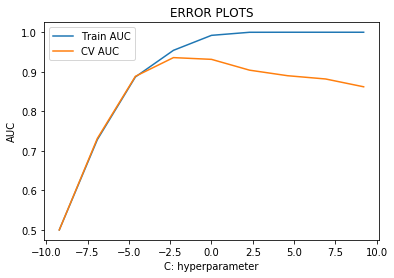

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c: 
    model = LogisticRegression(C=i,penalty='l1',class_weight='balanced')
    model.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

0.1


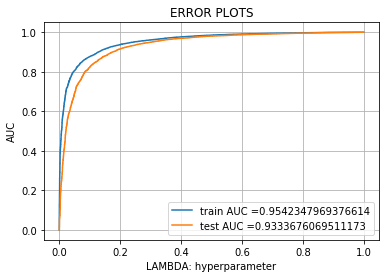

Train confusion matrix
[[ 5601   692]
 [ 3857 29250]]
Test confusion matrix
[[ 3966   689]
 [ 2944 21367]]


In [92]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_1 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_1)

model = LogisticRegression(C=opt_auc_1,penalty='l1',class_weight='balanced')
model.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test_bow)))

# Summarizing the values 
bow_train= train_auc
bow_test = cv_auc

BOW_test_L1=max(bow_test)

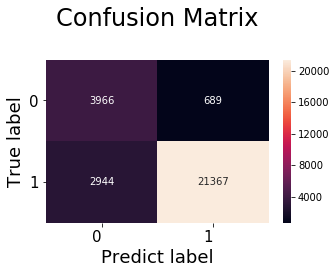

In [93]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(X_train_bow)) 
cm = confusion_matrix(y_test, model.predict(X_test_bow)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


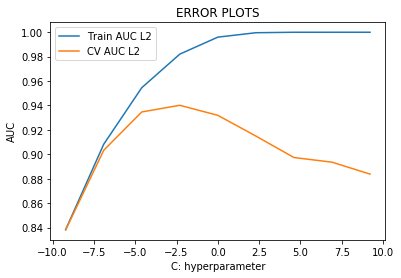

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l2',class_weight='balanced')
    model.fit(X_train_bow, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  model.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC L2')
plt.plot(np.log(c), cv_auc, label='CV AUC L2')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

0.1


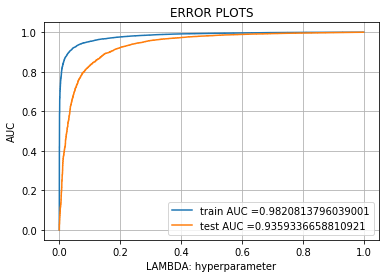

Train confusion matrix
[[ 5978   315]
 [ 2521 30586]]
Test confusion matrix
[[ 3859   796]
 [ 2352 21959]]


In [59]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_2 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_2)

model = LogisticRegression(C=opt_auc_2,penalty='l2',class_weight='balanced')
model.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(X_test_bow)))

# Summarizing the values 
bow_train= train_auc
bow_test = cv_auc

BOW_test_L2=max(bow_test)

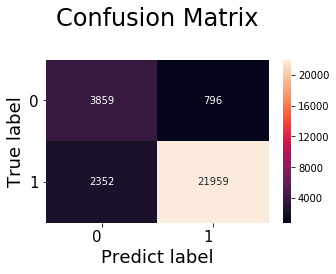

In [60]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(X_train_bow)) 
cm = confusion_matrix(y_test, model.predict(X_test_bow)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

## [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW, <font color='red'> SET 1</font>

In [61]:
#saidaml-github
model = LogisticRegression(C=10,penalty='l2')
model.fit(X_train_bow,y_train) 
weight1 = model.coef_ 
# the weight vector
# New dataset by adding a small noise
new_train = X_train_bow.astype(float) 
new_train.data += np.random.uniform(-0.0001,0.0001,1 )
# Fit the model on new data
model = LogisticRegression(C=1,penalty='l2') 
model.fit(X_train_bow,y_train)

weight2 =model.coef_
weight1 += 10**-6 
weight2 += 10**-6
percentage_change_vector = abs( (weight1-weight2) / (weight1) )*100


In [62]:
#print weights difference 
print(percentage_change_vector.max()) 
print(percentage_change_vector.min()) 
print(percentage_change_vector.std())


54985.404161594764
0.002377596376686705
1086.7802509341857


In [63]:
percentage_change=[] 
collinear_features=[]
for i in range(1,101): 
    f=np.where(percentage_change_vector > i)[1].size 
    percentage_change.append(i) 
    collinear_features.append(f)

In [64]:
feat = vectorizer.get_feature_names()
print("No of features have weight changes greater than 30%: ", percentage_change_vector[np.where(percentage_change_vector > 30)].size)
fe=[]
print("\ncollinear features are :") 
for i in np.where(percentage_change_vector > 1)[1]:
     fe.append(feat[i])
print(fe)

No of features have weight changes greater than 30%:  32198

collinear features are :


['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaarrrrrggghhh', 'aaaaah', 'aaah', 'aaahs', 'aafco', 'aahs', 'aamazon', 'aarti', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abb', 'abbaye', 'abbey', 'abbott', 'abbreviated', 'abby', 'abc', 'abcessed', 'abd', 'abdomen', 'abdominal', 'abhor', 'abide', 'abiding', 'abilities', 'ability', 'abilling', 'abit', 'ablaze', 'able', 'ablity', 'abnormal', 'abnormalities', 'abnormally', 'abnoxious', 'aboard', 'abolutely', 'abolutley', 'abomination', 'abominations', 'abondant', 'aboout', 'abor', 'aboslutely', 'abosolutly', 'abosoutely', 'abot', 'abottle', 'aboulutely', 'abound', 'abounds', 'aboutamazon', 'aboutmy', 'aboutone', 'aboutthe', 'abovethirst', 'aboviously', 'abowt', 'abrasive', 'abreakfast', 'abroad', 'abrubt', 'abrupt', 'abruptly', 'abruzzo', 'abs', 'absalutely', 'abscess', 'absconding', 'absence', 'absent', 'absinthe', 'absoloutely', 'absoluley', 'absolustely', 'absolute', 'absolutelly', 'absolutelty', 'absolutely', 'absolutley', 'abso

0 th percentile :  0.002377596376686705
10 th percentile :  23.477496719406343
20 th percentile :  42.30376273656644
30 th percentile :  54.38252202780258
40 th percentile :  62.57285833318443
50 th percentile :  69.23927737977571
60 th percentile :  76.61953933164781
70 th percentile :  91.83940451198413
80 th percentile :  227.7780490149668
90 th percentile :  791.4723782231146
100 th percentile :  54985.404161594764


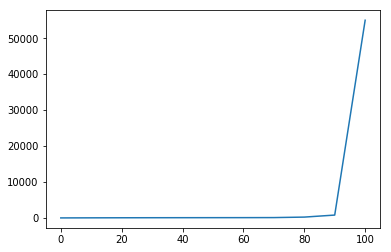

In [65]:
t = range(0,101,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

99.0 th percentile :  3830.9697046929864
99.11111111111111 th percentile :  3973.972048831286
99.22222222222223 th percentile :  4176.768460162084
99.33333333333333 th percentile :  4519.234312085925
99.44444444444444 th percentile :  4957.173889182212
99.55555555555556 th percentile :  5273.461576964199
99.66666666666667 th percentile :  5969.354709676953
99.77777777777777 th percentile :  7826.805268381718
99.88888888888889 th percentile :  9881.425519564304
100.0 th percentile :  54985.404161594764


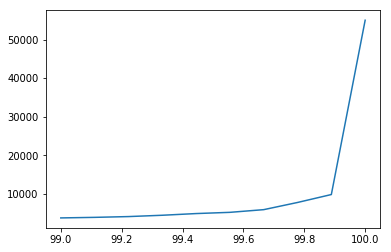

In [66]:
t = np.linspace(99,100,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [67]:
all_features = vectorizer.get_feature_names()
def most_informative_features(vectorizer, model, n= 25):
    feature_names = all_features
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))

In [68]:
 most_informative_features(X_train_bow,model)

		Positive					Negative
_________________________________________________________________________________ 

	2.1945	delicious      				-2.9917	worst          
	2.0059	pleasantly     				-2.6415	disappointing  
	1.9838	perfect        				-2.3402	sounded        
	1.8889	amazing        				-2.3354	terrible       
	1.8614	excellent      				-2.2618	rip            
	1.8541	hooked         				-2.2298	awful          
	1.8429	beat           				-2.1216	disappointment 
	1.8414	yummy          				-2.0351	died           
	1.8217	fantastic      				-2.0097	threw          
	1.7699	complaint      				-1.8832	horrible       
	1.7463	amazed         				-1.8807	hoping         
	1.7427	breath         				-1.8665	yuck           
	1.7279	awesome        				-1.8520	ripoff         
	1.6768	resist         				-1.8390	pass           
	1.6284	wonderful      				-1.8011	shame          
	1.6146	terrific       				-1.8010	tasteless      
	1.6063	skeptical      				-1.7654	tossing        
	1.5980	carrying       		

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [69]:
 most_informative_features(X_train_bow,model)

		Positive					Negative
_________________________________________________________________________________ 

	2.1945	delicious      				-2.9917	worst          
	2.0059	pleasantly     				-2.6415	disappointing  
	1.9838	perfect        				-2.3402	sounded        
	1.8889	amazing        				-2.3354	terrible       
	1.8614	excellent      				-2.2618	rip            
	1.8541	hooked         				-2.2298	awful          
	1.8429	beat           				-2.1216	disappointment 
	1.8414	yummy          				-2.0351	died           
	1.8217	fantastic      				-2.0097	threw          
	1.7699	complaint      				-1.8832	horrible       
	1.7463	amazed         				-1.8807	hoping         
	1.7427	breath         				-1.8665	yuck           
	1.7279	awesome        				-1.8520	ripoff         
	1.6768	resist         				-1.8390	pass           
	1.6284	wonderful      				-1.8011	shame          
	1.6146	terrific       				-1.8010	tasteless      
	1.6063	skeptical      				-1.7654	tossing        
	1.5980	carrying       		

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

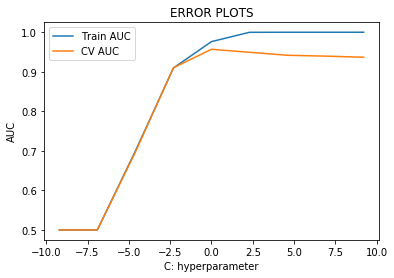

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l1',class_weight='balanced')
    model.fit(train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(train_tf_idf)[:,1]
    y_cv_pred =  model.predict_proba(cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

1


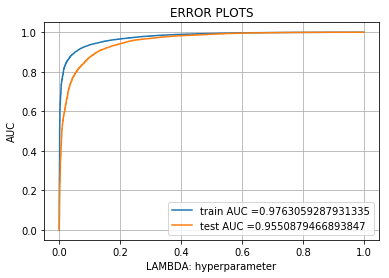

Train confusion matrix
[[ 5863   430]
 [ 2774 30333]]
Test confusion matrix
[[ 4039   616]
 [ 2254 22057]]


In [71]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_3 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_3)

model = LogisticRegression(C=opt_auc_3,penalty='l1',class_weight='balanced')
model.fit(train_tf_idf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(test_tf_idf)))

# Summarizing the values 
tfidf_train= train_auc
tfidf_test = cv_auc

TFIDF_test_L1=max(tfidf_test)

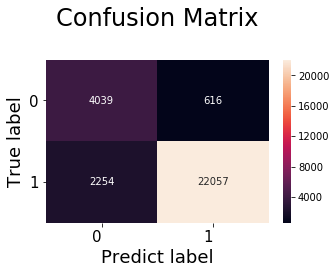

In [72]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(train_tf_idf)) 
cm = confusion_matrix(y_test, model.predict(test_tf_idf)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

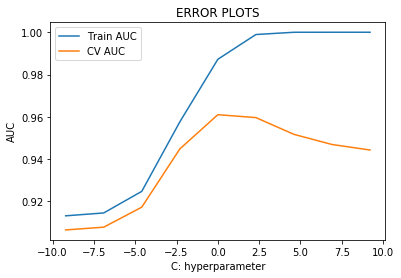

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l2',class_weight='balanced')
    model.fit(train_tf_idf, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(train_tf_idf)[:,1]
    y_cv_pred =  model.predict_proba(cv_tf_idf)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

1


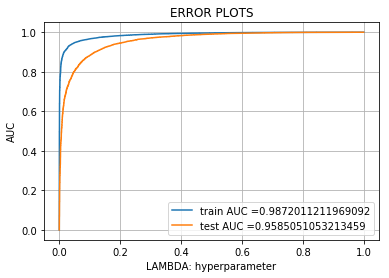

Train confusion matrix
[[ 6074   219]
 [ 2193 30914]]
Test confusion matrix
[[ 3995   660]
 [ 2026 22285]]


In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_4 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_4)

model = LogisticRegression(C=opt_auc_4,penalty='l2',class_weight='balanced')
model.fit(train_tf_idf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(train_tf_idf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(test_tf_idf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(test_tf_idf)))

# Summarizing the values 
tfidf_train= train_auc
tfidf_test = cv_auc

TFIDF_test_L2=max(tfidf_test)

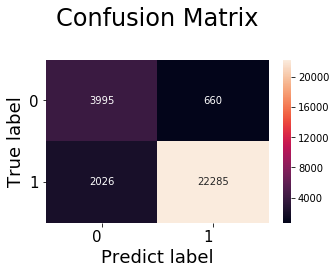

In [75]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(train_tf_idf)) 
cm = confusion_matrix(y_test, model.predict(test_tf_idf)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

#### [5.2.3.1] Top 10 important features of positive class and negative class from<font color='red'> SET 2</font>

In [76]:
all_features = tf_idf_vect.get_feature_names()
def most_informative_features(tf_idf_vect, model, n= 25):
    feature_names = all_features
    coefs_with_fns = sorted(zip(model.coef_[0], feature_names))
    top = zip(coefs_with_fns[:(n + 1): -1], coefs_with_fns[:n])
    print("\t\tPositive\t\t\t\t\tNegative")
    print("_________________________________________________________________________________ \n")
    for (coef_1, fn_2), (coef_2, fn_1) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_2, coef_2, fn_1))

In [77]:
most_informative_features(train_tf_idf,model)

		Positive					Negative
_________________________________________________________________________________ 

	10.5090	great          				-7.8041	disappointed   
	8.5506	delicious      				-7.6041	not            
	8.0929	best           				-6.3255	worst          
	7.6414	good           				-6.1593	disappointing  
	7.1378	perfect        				-5.9981	not good       
	6.0821	love           				-5.5733	terrible       
	5.9386	loves          				-5.5295	not recommend  
	5.8967	nice           				-5.2084	awful          
	5.3848	wonderful      				-5.0743	horrible       
	5.3298	excellent      				-5.0721	not worth      
	5.0562	favorite       				-4.9669	not buy        
	4.7851	happy          				-4.8802	bad            
	4.6477	amazing        				-4.4954	stale          
	4.1753	tasty          				-4.3610	unfortunately  
	4.1121	easy           				-4.2437	thought        
	4.0937	not disappointed				-4.2263	bland          
	4.0604	yummy          				-4.1603	return         
	3.9519	awesome        

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

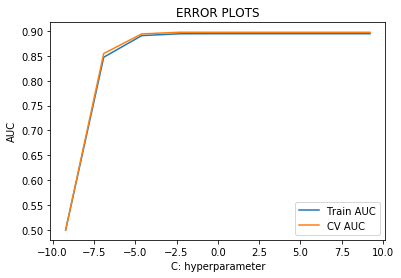

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l1',class_weight='balanced')
    model.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  model.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

0.1


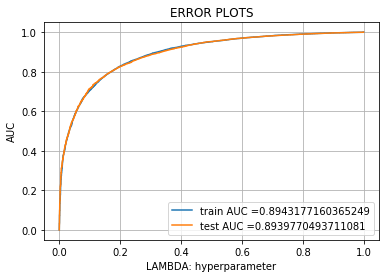

Train confusion matrix
[[ 5265  1028]
 [ 6835 26272]]
Test confusion matrix
[[ 3897   758]
 [ 5014 19297]]


In [79]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_5 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_5)

model = LogisticRegression(C=opt_auc_5,penalty='l1',class_weight='balanced')
model.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(sent_vectors_test)))

# Summarizing the values 
avgw2v_train= train_auc
avgw2v_test = cv_auc

AVGW2V_test_L1=max(avgw2v_test)

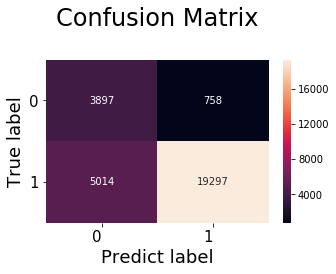

In [80]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(sent_vectors_train)) 
cm = confusion_matrix(y_test, model.predict(sent_vectors_test)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

### [5.3.1] Applying Logistic Regression with L2 regularization on AVG W2V<font color='red'> SET 3</font>

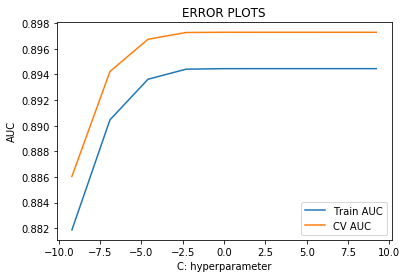

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l2',class_weight='balanced')
    model.fit(sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  model.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

1


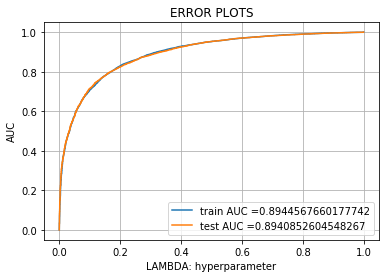

Train confusion matrix
[[ 5262  1031]
 [ 6810 26297]]
Test confusion matrix
[[ 3899   756]
 [ 4996 19315]]


In [82]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_6 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_6)

model = LogisticRegression(C=opt_auc_6,penalty='l2',class_weight='balanced')
model.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(sent_vectors_test)))

# Summarizing the values 
avgw2v_train= train_auc
avgw2v_test = cv_auc

AVGW2V_test_L2=max(avgw2v_test)

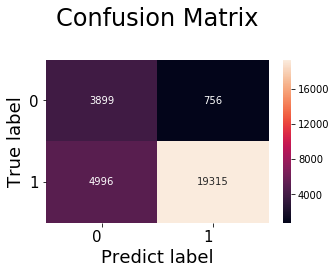

In [83]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(sent_vectors_train)) 
cm = confusion_matrix(y_test, model.predict(sent_vectors_test)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

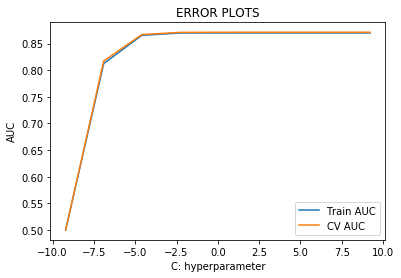

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l1',class_weight='balanced')
    model.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  model.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

100


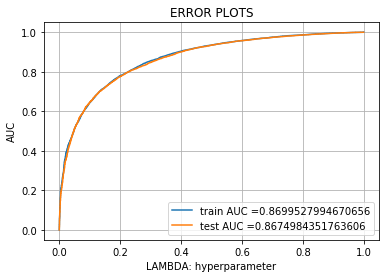

Train confusion matrix
[[ 5084  1209]
 [ 7547 25560]]
Test confusion matrix
[[ 3748   907]
 [ 5540 18771]]


In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_7 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_7)

model = LogisticRegression(C=opt_auc_7,penalty='l1',class_weight='balanced')
model.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(tfidf_sent_vectors_test)))

# Summarizing the values 
tfidf_w2v_train= train_auc
tfidf_w2v_test = cv_auc

TFIDF_W2V_test_L1=max(tfidf_w2v_test)

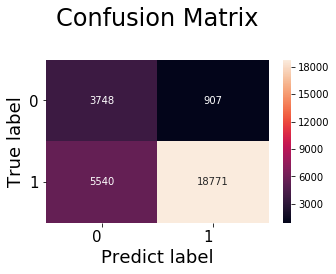

In [86]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(tfidf_sent_vectors_train)) 
cm = confusion_matrix(y_test, model.predict(tfidf_sent_vectors_test)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

### [5.4.1] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

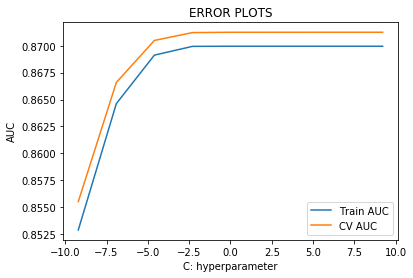

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import * 
from sklearn.linear_model import LogisticRegression 
from math import log 
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
c = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1,10**2,10**3, 10**4]
for i in c:
    model = LogisticRegression(C=i,penalty='l2',class_weight='balanced')
    model.fit(tfidf_sent_vectors_train, y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_train_pred =  model.predict_proba(tfidf_sent_vectors_train)[:,1]
    y_cv_pred =  model.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log(c), train_auc, label='Train AUC')
plt.plot(np.log(c), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

10000


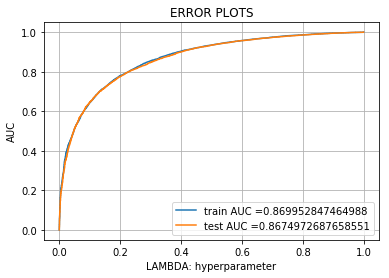

Train confusion matrix
[[ 5084  1209]
 [ 7547 25560]]
Test confusion matrix
[[ 3747   908]
 [ 5542 18769]]


In [88]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

opt_auc_8 = c[cv_auc.index(max(cv_auc))] 
print(opt_auc_8)

model = LogisticRegression(C=opt_auc_8,penalty='l2',class_weight='balanced')
model.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("LAMBDA: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, model.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, model.predict(tfidf_sent_vectors_test)))

# Summarizing the values 
tfidf_w2v_train= train_auc
tfidf_w2v_test = cv_auc

TFIDF_W2V_test_L2=max(tfidf_w2v_test)

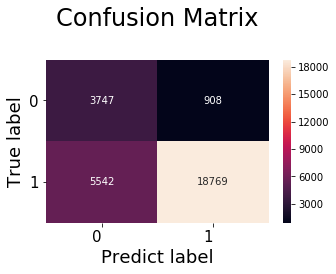

In [89]:
# CONFUSION MATRIX

cm = confusion_matrix(y_train, model.predict(tfidf_sent_vectors_train)) 
cm = confusion_matrix(y_test, model.predict(tfidf_sent_vectors_test)) 
tn, fp, fn, tp = cm.ravel() 

# Code for drawing seaborn heatmaps 
class_names = ['0','1'] 
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names ) 
fig = plt.figure(figsize=(5,3)) 
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=15)
plt.ylabel('True label',size=18) 
plt.xlabel('Predict label',size=18) 
plt.title("Confusion Matrix\n",size=24) 
plt.show()

# [6] Conclusions

In [94]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["S.NO","MODEL", "ALPHA","REGULARIZER","AUC"]

x.add_row(["1","BAG OF WORDS",BOW_test_L1,"L1",opt_auc_1])
x.add_row(["2","BAG OF WORDS",BOW_test_L2,"L2",opt_auc_2])
x.add_row(["3","TFIDF",TFIDF_test_L1,"L1",opt_auc_3])
x.add_row(["4","TFIDF",TFIDF_test_L2,"L2",opt_auc_4])
x.add_row(["5","AVGW2V",AVGW2V_test_L1,"L1",opt_auc_5])
x.add_row(["6","AVGW2V",AVGW2V_test_L2,"L2",opt_auc_6])
x.add_row(["7","TFIDFW2V",TFIDF_W2V_test_L1,"L1",opt_auc_7])
x.add_row(["8","TFIDFW2V",TFIDF_W2V_test_L2,"L2",opt_auc_8])

# Printing the Table
print(x)

+------+--------------+--------------------+-------------+-------+
| S.NO |    MODEL     |       ALPHA        | REGULARIZER |  AUC  |
+------+--------------+--------------------+-------------+-------+
|  1   | BAG OF WORDS | 0.9358312828350488 |      L1     |  0.1  |
|  2   | BAG OF WORDS | 0.9401681283012902 |      L2     |  0.1  |
|  3   |    TFIDF     | 0.9568641686674427 |      L1     |   1   |
|  4   |    TFIDF     | 0.9609814237534582 |      L2     |   1   |
|  5   |    AVGW2V    | 0.897369203019544  |      L1     |  0.1  |
|  6   |    AVGW2V    | 0.8973005099086562 |      L2     |   1   |
|  7   |   TFIDFW2V   | 0.8712484372412893 |      L1     |  100  |
|  8   |   TFIDFW2V   | 0.8712508086070325 |      L2     | 10000 |
+------+--------------+--------------------+-------------+-------+


1. The Linear Regression model in both the cases gave out 91.25% output(on an average).
2. BOW and TFIDF have given a better output when compared to all the 4 vectorizers.
3. If the number of data points to be classified is increased the output may be even more better, keeping in mind that the new    data points may be all negative, all positive or may be balanced.
4. If the points are imbalanced the classifier can have different situations to deal with.